In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

pd.options.display.max_columns = 999
sns.set_style('white')

In [2]:
df = pd.read_csv('census_income_2019.csv', compression = 'zip')
df.head()

,PWGTP,WGTP,PINCP,WKHP,WAGP,AGEP,FER,DIS,COW,CPLT,ADJINC,CIT,POBP,PARTNER,SEX,RAC1P,SCHL,OCCP,NAICSP,SERIALNO,SPORDER
0,71,0,63000,80,63000,35,0,2,1,0,1.010145,1,18,-1,1,1,17,6250,23,2019GQ0000001,1
1,67,0,0,0,0,25,0,2,0,0,1.010145,1,48,-1,1,1,12,9,-1,2019GQ0000004,1
2,24,0,2000,15,2000,21,2,2,2,0,1.010145,5,229,-1,2,6,19,4740,611M1,2019GQ0000007,1
3,52,0,0,0,0,49,0,2,1,0,1.010145,1,6,-1,1,1,21,110,722Z,2019GQ0000010,1
4,28,0,6000,15,6000,18,2,2,1,0,1.010145,1,6,-1,2,1,16,4110,722Z,2019GQ0000013,1


In [3]:
df.shape

(3239553, 21)

##### Update Column Names

In [4]:
org_vars = """PINCP
WAGP
INTP
ADJINC
PWGTP
OCCP
NAICSP
WKHP
AGEP
SEX
FER
CPLT
PARTNER
COW
RAC1P
POBP
CIT
SCHL
DIS
SERIALNO
SPORDER
WAOB""".split("\n")

In [5]:
uptd_vars = """INCOME
SALARY
INTEREST_DIV
ADJINC
FNLWGT
OCCUPATION
WORK_INDUSTRY
WKLY_HRS
AGE
SEX
MOM
COUPLE
PARTNER
WORK_CLASS
RACE
POB_DETAIL
CITIZENSHIP
EDUCATION
DIS
SERIALNO
PERSON_NO
POB_WORLD""".split("\n")

In [6]:
vars_dict = dict(zip(org_vars, uptd_vars))
# vars_dict #Uncomment to view

In [7]:
df = df.rename(columns=vars_dict)
df.head() #Sanity Check

,FNLWGT,WGTP,INCOME,WKLY_HRS,SALARY,AGE,MOM,DIS,WORK_CLASS,COUPLE,ADJINC,CITIZENSHIP,POB_DETAIL,PARTNER,SEX,RACE,EDUCATION,OCCUPATION,WORK_INDUSTRY,SERIALNO,PERSON_NO
0,71,0,63000,80,63000,35,0,2,1,0,1.010145,1,18,-1,1,1,17,6250,23,2019GQ0000001,1
1,67,0,0,0,0,25,0,2,0,0,1.010145,1,48,-1,1,1,12,9,-1,2019GQ0000004,1
2,24,0,2000,15,2000,21,2,2,2,0,1.010145,5,229,-1,2,6,19,4740,611M1,2019GQ0000007,1
3,52,0,0,0,0,49,0,2,1,0,1.010145,1,6,-1,1,1,21,110,722Z,2019GQ0000010,1
4,28,0,6000,15,6000,18,2,2,1,0,1.010145,1,6,-1,2,1,16,4110,722Z,2019GQ0000013,1


In [8]:
df.head()

,FNLWGT,WGTP,INCOME,WKLY_HRS,SALARY,AGE,MOM,DIS,WORK_CLASS,COUPLE,ADJINC,CITIZENSHIP,POB_DETAIL,PARTNER,SEX,RACE,EDUCATION,OCCUPATION,WORK_INDUSTRY,SERIALNO,PERSON_NO
0,71,0,63000,80,63000,35,0,2,1,0,1.010145,1,18,-1,1,1,17,6250,23,2019GQ0000001,1
1,67,0,0,0,0,25,0,2,0,0,1.010145,1,48,-1,1,1,12,9,-1,2019GQ0000004,1
2,24,0,2000,15,2000,21,2,2,2,0,1.010145,5,229,-1,2,6,19,4740,611M1,2019GQ0000007,1
3,52,0,0,0,0,49,0,2,1,0,1.010145,1,6,-1,1,1,21,110,722Z,2019GQ0000010,1
4,28,0,6000,15,6000,18,2,2,1,0,1.010145,1,6,-1,2,1,16,4110,722Z,2019GQ0000013,1


In [9]:
#checking for duplicates
df.duplicated().sum()

0

In [10]:
##Remove MOM, DIS, SERIALNO and PERSON_NO here?
df = df.drop(['DIS','ADJINC','SERIALNO', 'PERSON_NO'], axis=1)

# Cleaning

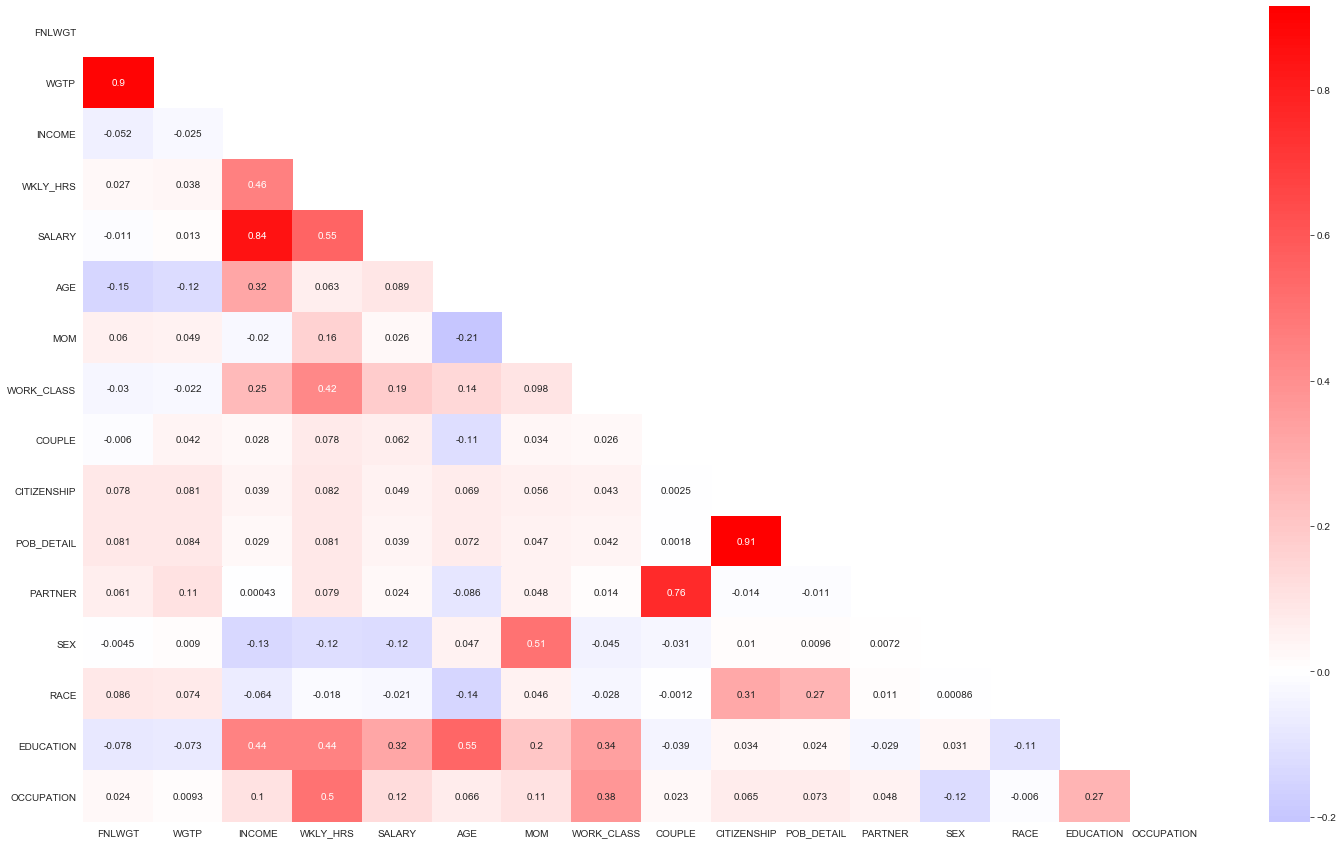

In [11]:
#create a heatmap to visualize the correlations
fig, ax = plt.subplots(figsize=(25,15)) # figsize to make larger
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask=mask, cmap='bwr', center=0, annot=True)

# fix for matplotlib bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

plt.show()

In [12]:
# narrow down data to adults over the 17 years old
df = df[df.AGE > 17]

In [13]:
df.shape

(2599171, 17)

In [14]:
# narrow down data to adults who worked in the past 12 months
df = df[df.WKLY_HRS > 0]

In [15]:
df.shape

(1659727, 17)

In [16]:
df.describe()

,FNLWGT,WGTP,INCOME,WKLY_HRS,SALARY,AGE,MOM,WORK_CLASS,COUPLE,CITIZENSHIP,POB_DETAIL,PARTNER,SEX,RACE,EDUCATION,OCCUPATION
count,1.659727e+06,1.659727e+06,1.659727e+06,1.659727e+06,1.659727e+06,1.659727e+06,1.659727e+06,1.659727e+06,1.659727e+06,1.659727e+06,1.659727e+06,1.659727e+06,1.659727e+06,1.659727e+06,1.659727e+06,1.659727e+06
mean,1.033513e+02,9.579058e+01,6.058823e+04,3.839128e+01,5.189937e+04,4.390527e+01,5.906477e-01,2.103359e+00,8.639788e-01,1.519284e+00,6.538772e+01,2.079902e-01,1.478681e+00,1.873518e+00,1.871658e+01,4.088068e+03
std,9.061065e+01,8.493126e+01,7.691692e+04,1.310493e+01,6.724644e+04,1.525340e+01,9.042176e-01,1.827131e+00,8.056928e-01,1.227446e+00,9.273321e+01,8.872759e-01,4.995454e-01,2.079837e+00,3.274921e+00,2.685733e+03
min,1.000000e+00,0.000000e+00,-1.020000e+04,1.000000e+00,0.000000e+00,1.800000e+01,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,-1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+01
25%,5.100000e+01,4.800000e+01,2.100000e+04,3.500000e+01,1.450000e+04,3.100000e+01,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.800000e+01,0.000000e+00,1.000000e+00,1.000000e+00,1.600000e+01,2.040000e+03
50%,7.900000e+01,7.400000e+01,4.024000e+04,4.000000e+01,3.540000e+04,4.400000e+01,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.600000e+01,0.000000e+00,1.000000e+00,1.000000e+00,1.900000e+01,4.110000e+03
75%,1.230000e+02,1.160000e+02,7.200000e+04,4.200000e+01,6.500000e+04,5.600000e+01,2.000000e+00,3.000000e+00,1.000000e+00,1.000000e+00,4.800000e+01,0.000000e+00,2.000000e+00,1.000000e+00,2.100000e+01,5.740000e+03
max,2.408000e+03,2.377000e+03,1.629000e+06,9.900000e+01,7.170000e+05,9.600000e+01,2.000000e+00,8.000000e+00,4.000000e+00,5.000000e+00,5.540000e+02,4.000000e+00,2.000000e+00,9.000000e+00,2.400000e+01,9.830000e+03


##### Binning Variables

**CITIZENSHIP**

In [17]:
# 1 indicating born in US, 0 indicating born outside of US
df['CITIZENSHIP'] = np.where(df['CITIZENSHIP']==1 , 1, 0)

**OCCUPATION**

In [18]:
# Binning Occupations

conditions = [ 
    ((df['OCCUPATION'] >= 10) & (df['OCCUPATION'] <= 440)), #MGR
    ((df['OCCUPATION'] >= 500) & (df['OCCUPATION'] <= 750)), #BUS
    ((df['OCCUPATION'] >= 800) & (df['OCCUPATION'] <= 960)), #FIN
    ((df['OCCUPATION'] >= 1005) & (df['OCCUPATION'] <= 1240)), #CMM
    ((df['OCCUPATION'] >= 1305) & (df['OCCUPATION'] <= 1560)), #ENG
    ((df['OCCUPATION'] >= 1600) & (df['OCCUPATION'] <= 1980)), #SCI
    ((df['OCCUPATION'] >= 2001) & (df['OCCUPATION'] <= 2060)), #CMS 
    ((df['OCCUPATION'] >= 2100) & (df['OCCUPATION'] <= 2180)), #LGL
    ((df['OCCUPATION'] >= 2205) & (df['OCCUPATION'] <= 2555)), #EDU
    ((df['OCCUPATION'] >= 2600) & (df['OCCUPATION'] <= 2920)), #ENT 
    ((df['OCCUPATION'] >= 3000) & (df['OCCUPATION'] <= 3550)), #MED
    ((df['OCCUPATION'] >= 3610) & (df['OCCUPATION'] <= 3655)), #HLS
    ((df['OCCUPATION'] >= 3700) & (df['OCCUPATION'] <= 3960)), #PRT 
    ((df['OCCUPATION'] >= 4000) & (df['OCCUPATION'] <= 4160)), #EAT
    ((df['OCCUPATION'] >= 4200) & (df['OCCUPATION'] <= 4255)), #CLN
    ((df['OCCUPATION'] >= 4330) & (df['OCCUPATION'] <= 4655)), #PRS
    ((df['OCCUPATION'] >= 4700) & (df['OCCUPATION'] <= 4965)), #SAL
    ((df['OCCUPATION'] >= 5000) & (df['OCCUPATION'] <= 5940)), #OFF
    ((df['OCCUPATION'] >= 6005) & (df['OCCUPATION'] <= 6130)), #FFF
    ((df['OCCUPATION'] >= 6200) & (df['OCCUPATION'] <= 6765)), #CON
    ((df['OCCUPATION'] >= 6800) & (df['OCCUPATION'] <= 6950)), #EXT
    ((df['OCCUPATION'] >= 7000) & (df['OCCUPATION'] <= 7640)), #RPR
    ((df['OCCUPATION'] >= 7700) & (df['OCCUPATION'] <= 8990)), #PRD
    ((df['OCCUPATION'] >= 9005) & (df['OCCUPATION'] <= 9760)), #TRN
    ((df['OCCUPATION'] >= 9800) & (df['OCCUPATION'] <= 9830)), #MIL
]

choices = [
    'MGR', 
    'BUS', 
    'FIN',
    'CMM', 
    'ENG', 
    'SCI',
    'CMS', 
    'LGL', 
    'EDU',
    'ENT', 
    'MED', 
    'HLS',
    'PRT', 
    'EAT', 
    'CLN',
    'PRS', 
    'SAL', 
    'OFF',
    'FFF', 
    'CON', 
    'EXT',
    'RPR',
    'PRD', 
    'TRN', 
    'MIL',
]

df['OCCUPATION'] = np.select(conditions, choices, default='NA')

In [19]:
# df.OCCUPATION.value_counts() #Sanity Check

**WORK_INDUSTRY**

# FIGURE OUT WORK_INDUSTRY

In [20]:
df.WORK_INDUSTRY

0             23
2          611M1
4           722Z
11           337
13         611M1
           ...  
3239548     5616
3239549    56173
3239550     5412
3239551       23
3239552     622M
Name: WORK_INDUSTRY, Length: 1659727, dtype: object

In [21]:
# Removing letters from values 
df['WORK_INDUSTRY'] = df.WORK_INDUSTRY.apply(lambda x: ''.join([num for num in x if num.isnumeric()]))


In [22]:
# # TESTING VARIATIONS
# def first_digits(num):
#     while i in num[:1] == 9:
#         return int(num[:3])
#     else:
#         return int(num[:2])


In [23]:
def first_digits(num):
    return int(num[:2])
df.WORK_INDUSTRY.apply(first_digits).sort_values()
# #Uncomment when ready to apply to df:
# df['WORK_INDUSTRY'] = df.WORK_INDUSTRY.apply(first_digits).sort_values() 
# df.WORK_INDUSTRY.value_counts().sort_index() #Sanity Check

163677      3
560897      3
560831      3
2745785     3
2745572     3
           ..
1113334    92
2195247    92
1113320    92
407056     92
2554397    92
Name: WORK_INDUSTRY, Length: 1659727, dtype: int64

In [24]:
df.head()

,FNLWGT,WGTP,INCOME,WKLY_HRS,SALARY,AGE,MOM,WORK_CLASS,COUPLE,CITIZENSHIP,POB_DETAIL,PARTNER,SEX,RACE,EDUCATION,OCCUPATION,WORK_INDUSTRY
0,71,0,63000,80,63000,35,0,1,0,1,18,-1,1,1,17,CON,23
2,24,0,2000,15,2000,21,2,2,0,0,229,-1,2,6,19,SAL,6111
4,28,0,6000,15,6000,18,2,1,0,1,6,-1,2,1,16,EAT,722
11,70,0,3200,40,3200,50,0,1,0,1,45,-1,1,2,16,TRN,337
13,45,0,500,12,500,19,2,4,0,1,12,-1,2,1,18,OFF,6111


In [25]:
# # Binning Industry

# conditions = [ 
#     (df['WORK_INDUSTRY'] == 11), #AGR
#     (df['WORK_INDUSTRY'] == 21), #EXT
#     (df['WORK_INDUSTRY'] == 22), #UTL
#     (df['WORK_INDUSTRY'] == 23), #CON
#     ((df['WORK_INDUSTRY'] >= 30) & (df['WORK_INDUSTRY'] <= 33)), #MFG  ADD 3
#     (df['WORK_INDUSTRY'] == 42), #WHL
#     ((df['WORK_INDUSTRY'] >= 44) & (df['WORK_INDUSTRY'] <= 45)), #RET ADD 4
#     ((df['WORK_INDUSTRY'] >= 48) & (df['WORK_INDUSTRY'] <= 49)), #TRN
#     (df['WORK_INDUSTRY'] == 51), # INF
#     ((df['WORK_INDUSTRY'] >= 52) & (df['WORK_INDUSTRY'] <= 53)), # FIN
#     ((df['WORK_INDUSTRY'] >= 54) & (df['WORK_INDUSTRY'] <= 56)), #PRF
#     (df['WORK_INDUSTRY'] == 61), #EDU
#     (df['WORK_INDUSTRY'] == 62), #MED/SCA
#     ((df['WORK_INDUSTRY'] >= 71) & (df['WORK_INDUSTRY'] <= 72)), #ENT
#     (df['WORK_INDUSTRY'] >= 81), # SRV
# #     ((df['WORK_INDUSTRY'] >= 921) & (df['WORK_INDUSTRY'] <= 923)), #ADM
# #     ((df['WORK_INDUSTRY'] == 928) & (df['WORK_INDUSTRY'] <= 4255)), #MIL
# ]

# choices = [
#     'AGR',
#     'EXT',
#     'UTL',
#     'CON',
#     'MFG',
#     'WHL',
#     'RET',
#     'TRN',
#     'INF',
#     'FIN',
#     'PRF',
#     'EDU',
#     'MED',
#     'ENT',
#     'SRV',
# #     'ADM',
# #     'MIL'
# ]

# # df['OCCUPATION'] = np.select(conditions, choices, default='NA')

In [26]:
##Saving this code because it works, but I still need to figure out how to 
# # Binning Industry

# conditions = [ 
#     (df['WORK_INDUSTRY'] == 11), #AGR
#     (df['WORK_INDUSTRY'] == 21), #EXT
#     (df['WORK_INDUSTRY'] == 22), #UTL
#     (df['WORK_INDUSTRY'] == 23), #CON
#     ((df['WORK_INDUSTRY'] >= 30) & (df['WORK_INDUSTRY'] <= 33)), #MFG  ADD 3
#     (df['WORK_INDUSTRY'] == 42), #WHL
#     ((df['WORK_INDUSTRY'] >= 44) & (df['WORK_INDUSTRY'] <= 45)), #RET ADD 4
#     ((df['WORK_INDUSTRY'] >= 48) & (df['WORK_INDUSTRY'] <= 49)), #TRN
#     (df['WORK_INDUSTRY'] == 51), # INF
#     ((df['WORK_INDUSTRY'] >= 52) & (df['WORK_INDUSTRY'] <= 53)), # FIN
#     ((df['WORK_INDUSTRY'] >= 54) & (df['WORK_INDUSTRY'] <= 56)), #PRF
#     (df['WORK_INDUSTRY'] == 61), #EDU
#     (df['WORK_INDUSTRY'] == 62), #MED/SCA
#     ((df['WORK_INDUSTRY'] >= 71) & (df['WORK_INDUSTRY'] <= 72)), #ENT
#     (df['WORK_INDUSTRY'] == 81) # SRV
# ]
# choices = [
#     'AGR',
#     'EXT',
#     'UTL',
#     'CON',
#     'MFG',
#     'WHL',
#     'RET',
#     'TRN',
#     'INF',
#     'FIN',
#     'PRF',
#     'EDU',
#     'MED',
#     'ENT',
#     'SRV'
# ]

# df['WORK_INDUSTRY2'] = np.select(conditions, choices, default='NA')

In [27]:
# Sanity Check
# df.WORK_INDUSTRY.value_counts()
# df.WORK_INDUSTRY.isnull().sum()

# Exploring Target Variable

In [28]:
df['TARGET'] = np.where(df.INCOME > 65000, '>65k', '<=65k')
df.TARGET.value_counts()

<=65k    1183289
>65k      476438
Name: TARGET, dtype: int64

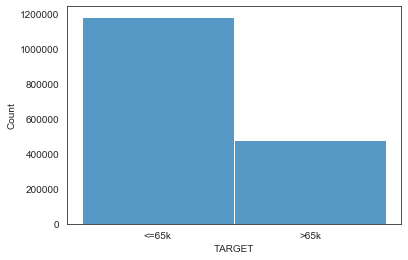

In [29]:
sns.histplot(data = df, x="TARGET")
plt.show()

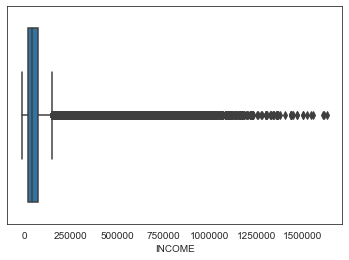

In [30]:
sns.boxplot(x=df.INCOME)


In [31]:
df.INCOME.describe()

count    1.659727e+06
mean     6.058823e+04
std      7.691692e+04
min     -1.020000e+04
25%      2.100000e+04
50%      4.024000e+04
75%      7.200000e+04
max      1.629000e+06
Name: INCOME, dtype: float64

In [32]:
df.INCOME

0           63000
2            2000
4            6000
11           3200
13            500
            ...  
3239548    150000
3239549     27000
3239550     75000
3239551     57000
3239552     55000
Name: INCOME, Length: 1659727, dtype: int64

In [33]:
df[df.INCOME > 100]['INCOME'].describe()

count    1.656282e+06
mean     6.071761e+04
std      7.694438e+04
min      1.040000e+02
25%      2.100000e+04
50%      4.050000e+04
75%      7.200000e+04
max      1.629000e+06
Name: INCOME, dtype: float64

In [34]:
df.SALARY.describe()

count    1.659727e+06
mean     5.189937e+04
std      6.724644e+04
min      0.000000e+00
25%      1.450000e+04
50%      3.540000e+04
75%      6.500000e+04
max      7.170000e+05
Name: SALARY, dtype: float64

# EDA

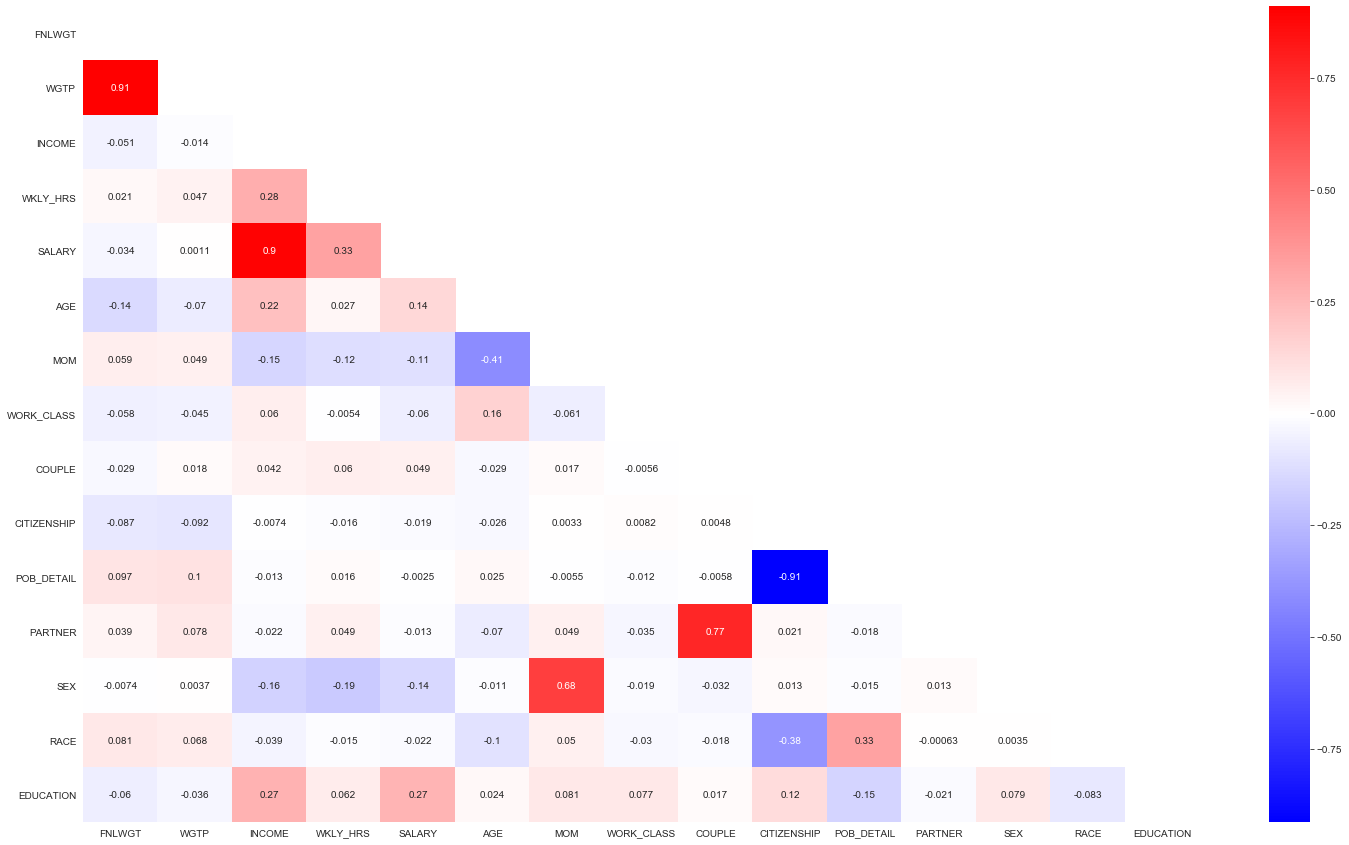

In [35]:
#create a heatmap to visualize the correlations
fig, ax = plt.subplots(figsize=(25,15)) # figsize to make larger
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask=mask, cmap='bwr', center=0, annot=True)

# fix for matplotlib bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

plt.show()

In [36]:
df.EDUCATION.value_counts()

21    378817
16    342093
19    250254
22    166793
20    154487
18    120758
17     56487
23     42571
24     29033
15     26173
14     23779
1      15897
13     15039
12     12130
9       8507
11      8136
10      2418
8       1794
6       1670
7       1112
5        797
4        423
2        298
3        261
Name: EDUCATION, dtype: int64

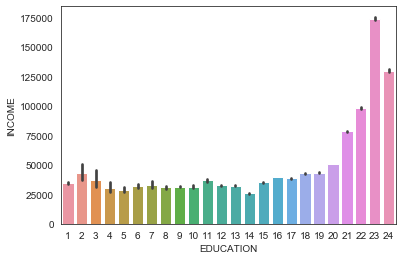

In [37]:
sns.barplot(data=df, x='EDUCATION', y='INCOME')

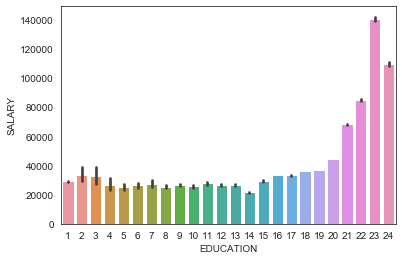

In [38]:
sns.barplot(data=df, x='EDUCATION', y='SALARY')

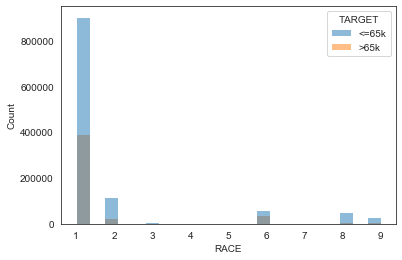

In [39]:
sns.histplot(data = df, x="RACE", hue = "TARGET")
plt.show()

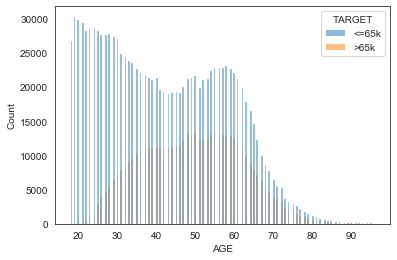

In [40]:
sns.histplot(data = df, x="AGE", hue = "TARGET")
plt.show()

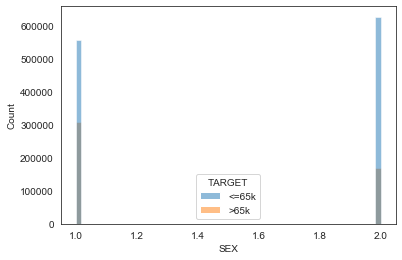

In [41]:
sns.histplot(data = df, x="SEX", hue = "TARGET")
plt.show()

In [42]:
df.SEX.value_counts()

1    865247
2    794480
Name: SEX, dtype: int64

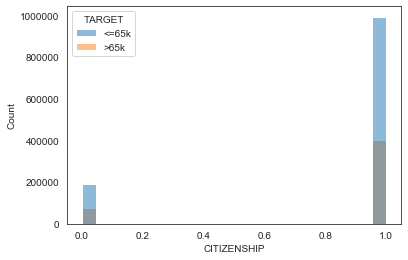

In [43]:
sns.histplot(data = df, x="CITIZENSHIP", hue = "TARGET")
plt.show()

In [44]:
# 1	Opposite-sex husband/wife/spouse household
# 2	Same-sex husband/wife/spouse household
# 3	Opposite-sex unmarried partner household
# 4	Same-sex unmarried partner household

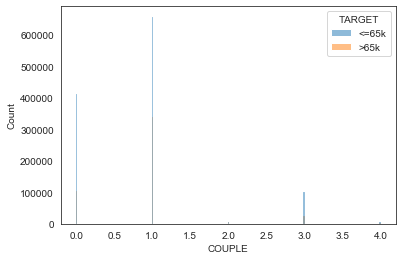

In [45]:
sns.histplot(data = df, x="COUPLE", hue = "TARGET")
plt.show()

In [46]:
# -1	N/A (GQ/vacant)
# 0	No unmarried partner in household
# 1	Male householder, male partner
# 2	Male householder, female partner
# 3	Female householder, female partner
# 4	Female householder, male partner

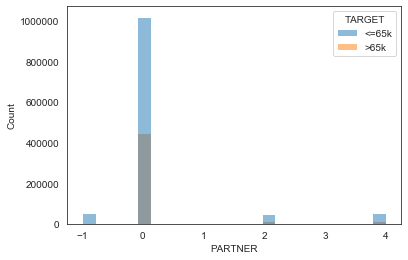

In [47]:
sns.histplot(data = df, x="PARTNER", hue = "TARGET")
plt.show()

In [48]:
df.PARTNER.value_counts()

 0    1468733
 4      64335
 2      63778
-1      55170
 3       3885
 1       3826
Name: PARTNER, dtype: int64

In [49]:
# sns.histplot(data = df, x="POB_WORLD", hue = "TARGET_60")

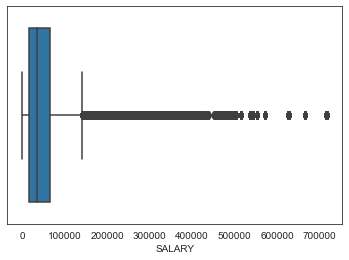

In [50]:
sns.boxplot(x=df.SALARY)


In [51]:
df.INCOME.median()

40240.0

In [52]:
df.SALARY.median()

35400.0

# Prepare Data for Modeling
- LabelEncoder
- remove unnecessary variables
- train-test split


In [53]:
# define cols
le = LabelEncoder()
cols = ['OCCUPATION', 'WORK_INDUSTRY']
df.loc[:,cols] = df.loc[:,cols].apply(le.fit_transform)

In [54]:
X = df.drop(['TARGET','INCOME', 'SALARY'], axis=1)
y = df.TARGET

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

In [56]:
df.head(2) #Sanity Check

,FNLWGT,WGTP,INCOME,WKLY_HRS,SALARY,AGE,MOM,WORK_CLASS,COUPLE,CITIZENSHIP,POB_DETAIL,PARTNER,SEX,RACE,EDUCATION,OCCUPATION,WORK_INDUSTRY,TARGET
0,71,0,63000,80,63000,35,0,1,0,1,18,-1,1,1,17,4,17,<=65k
2,24,0,2000,15,2000,21,2,2,0,0,229,-1,2,6,19,23,203,<=65k


# Model Testing

In [57]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)

In [58]:
accuracy_score(y_test, y_pred)

0.7597437652434615

In [59]:
importance = tree.feature_importances_
feat_imp_dict = dict(zip(X.columns, importance))

In [60]:
feat_imp_dict

{'FNLWGT': 0.10609208678588701,
 'WGTP': 0.10625187250947501,
 'WKLY_HRS': 0.10341417804103596,
 'AGE': 0.14183970968089873,
 'MOM': 0.0038820711568278675,
 'WORK_CLASS': 0.027866749927783693,
 'COUPLE': 0.017783993819359793,
 'CITIZENSHIP': 0.002737407412536461,
 'POB_DETAIL': 0.10189099095770214,
 'PARTNER': 0.006739637899674568,
 'SEX': 0.021635514284834116,
 'RACE': 0.017367279841005515,
 'EDUCATION': 0.16390169395492662,
 'OCCUPATION': 0.07107452147266016,
 'WORK_INDUSTRY': 0.10752229225539231}